# Análise Estatística

Antes de iniciar o processo de análise, os primeiros passos foram agregar as tabelas, entender quais colunas existiam, quais poderiam ser substituidas, e quais eram relevantes para o problema de combinação.

## Dados

### Importando Bibliotecas

In [77]:
!pip install pandas_market_calendars

In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas_market_calendars as mcal

In [79]:
import matplotlib.pyplot as plt

### Carregando os dados

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
vendas = pd.read_csv('/content/drive/MyDrive/Datasets/vendas_dataset.csv')
compras = pd.read_csv('/content/drive/MyDrive/Datasets/compras_dataset.csv')

<ipython-input-81-491e1e8d8622>:2: DtypeWarning: Columns (6,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  compras = pd.read_csv('/content/drive/MyDrive/Datasets/compras_dataset.csv')


### Convertendo os dados
Pequenos processos e tratamento de dados, para uma observação incial. Isso inclui a transformação de colunas em texto para o tipo "Data", ou em números inteiros / floats.

In [82]:
vendas['Dt. Operação'] = pd.to_datetime(vendas['Dt. Operação'], format="%m/%d/%Y")
vendas['Vencimento'] = pd.to_datetime(vendas['Vencimento'], format="%m/%d/%Y")
compras['Dt. Operação'] = pd.to_datetime(compras['Dt. Operação'], format="%Y/%m/%d")

for col in ['Quantidade', 'Preço', 'Valor Líquido']:
    vendas[col] = vendas[col].str.replace(',', '').astype(float)
    compras[col] = compras[col].str.replace(',', '').astype(float)

vendas['DI'] = vendas['DI'].str.replace('%', '').astype(float) / 100
vendas['Preço'] = vendas['Preço'].astype(float)
compras['Preço'] = compras['Preço'].astype(float)

In [83]:
dtypes_vendas = vendas.dtypes
dtypes_compras = compras.dtypes

dtypes_vendas, dtypes_compras

(Unnamed: 0                 int64
 Chave                     object
 Cód. Cliente              object
 Dt. Operação      datetime64[ns]
 Tipo Operação             object
 Cód. Título               object
 Cód. Corretora            object
 Quantidade               float64
 Preço                    float64
 Valor Líquido            float64
 Vencimento        datetime64[ns]
 Tipo                      object
 DI                       float64
 dtype: object,
 Unnamed: 0                 int64
 Cód. Cliente              object
 Dt. Operação      datetime64[ns]
 Tipo Operação             object
 Cód. Título               object
 Cód. Corretora            object
 Quantidade               float64
 Preço                    float64
 Valor Líquido            float64
 Dt. Liquidação            object
 Tipo                      object
 Vencimento                object
 dtype: object)

### Criando nova coluna "UniqueID"
Visto que as Colunas Código Cliente, Código Título, Código Corretora e Data da operação descrevem de forma agregada, uma maneira de identificar chaves para casamentos e combinações, decidimos então criar uma coluna chamada UniqueID, a qual agregava os 3 valores em uma só, facilitando processos futuros de agrupamento e Match.

In [84]:
vendas['UniqueID'] = vendas['Cód. Cliente'] + '_' + vendas['Dt. Operação'].astype(str) + '_' + vendas['Cód. Título'] + '_' + vendas['Cód. Corretora']
compras['UniqueID'] = compras['Cód. Cliente'] + '_' + compras['Dt. Operação'].astype(str) + '_' + compras['Cód. Título'] + '_' + compras['Cód. Corretora']
df_vendas_final = vendas.drop([ 'Cód. Cliente', 'Cód. Título', 'Cód. Corretora', 'Tipo'], axis=1)
df_compras_final = compras.drop(['Cód. Cliente', 'Vencimento', 'Cód. Título', 'Cód. Corretora', 'Tipo', 'Dt. Liquidação'], axis=1)

In [85]:
df_vendas_final.head()

,Unnamed: 0,Chave,Dt. Operação,Tipo Operação,Quantidade,Preço,Valor Líquido,Vencimento,DI,UniqueID
0,0,B2,2022-04-01,V,8942.0,18.20,162754.49,2023-08-18,0.1230,Cliente 10_2022-04-01_ABCB4_STDE
1,1,B3,2022-06-23,V,9512.0,14.84,141162.79,2023-10-23,0.1321,Cliente 10_2022-06-23_ABCB4_AGOR
2,2,B4,2022-08-26,V,12907.0,22.51,290493.57,2023-03-22,0.1374,Cliente 10_2022-08-26_ABCB4_TERR
3,3,B5,2022-05-30,V,5088.0,14.49,73724.16,2022-06-28,0.1286,Cliente 10_2022-05-30_ABEV3_MIRA
4,4,B6,2022-10-19,V,226229.0,1.83,413603.52,2023-09-01,0.1333,Cliente 10_2022-10-19_AERI3_AGOR


In [86]:
df_compras_final.head()

,Unnamed: 0,Dt. Operação,Tipo Operação,Quantidade,Preço,Valor Líquido,UniqueID
0,0,2022-04-01,C,1236.0,15.56,-19232.17,Cliente 10_2022-04-01_ABCB4_STDE
1,1,2022-04-01,C,1360.0,15.88,-21593.84,Cliente 10_2022-04-01_ABCB4_STDE
2,2,2022-04-01,C,1755.0,15.51,-27225.68,Cliente 10_2022-04-01_ABCB4_STDE
3,3,2022-04-01,C,1567.0,15.67,-24553.20,Cliente 10_2022-04-01_ABCB4_STDE
4,4,2022-04-01,C,1271.0,15.60,-19833.77,Cliente 10_2022-04-01_ABCB4_STDE


## Exploração Casamento Manual
Com foco em extrair alguns casamentos, mesmo que de forma artificial, para exploração, foram agrupados então, vendas e casamentos, com base na coluna anterior, para posterior combinação.

In [87]:
df_vendas_grouped = df_vendas_final.groupby("UniqueID")
df_compras_grouped = df_compras_final.groupby("UniqueID")

### Funções Auxiliares
Para validar os casamentos, foi necessário a criação de duas funções auxiliares:
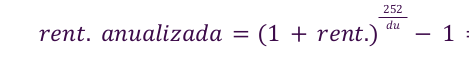

1. Calc Rent - Tem como objetivo calcular a rentabilidade baseada no CDI, de um casamento, com base nos valores de compra, venda, taxa DU ($ \frac{252}{du} $), além do índice DI.

In [88]:
def calc_rent(buy_value, sell_value, du_idx, di_rent):
  buy_sell_rent = (sell_value / buy_value) - 1
  rent_anual = (1 + buy_sell_rent) ** du_idx - 1
  rent_over_cdi = rent_anual / di_rent
  return rent_over_cdi

2. Calc DU IDX - Tem como objetivo calcular a taxa DU, relativa aos dias úteis. Nesse caso, foi necessário levar em consideração o calendário brasileiro da bolsa, para a contagem dos dias.

In [89]:
brazil_calendar = mcal.get_calendar('BMF')

def calc_du_idx(start_date,end_date):
  time_frame = brazil_calendar.schedule(start_date, end_date)
  date_range = mcal.date_range(time_frame, frequency='1D')
  return 252 / (len(date_range) - 1)

Exemplo de uso:

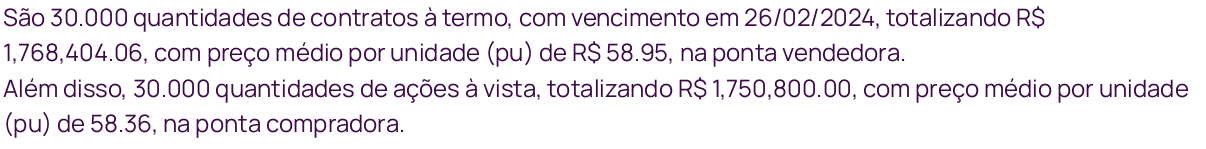

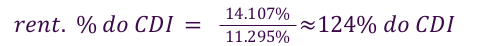

In [90]:
from datetime import datetime
du = calc_du_idx(datetime(2024, 1, 26), datetime(2024, 2, 26))
calc_rent(58.36317,58.946802, du, 0.11295)

1.249024958621961

### Processo de Casamento
Então, tentamos os casamentos hipotéticos, agrupando as compras com base no preço médio, além do ID mencionado anteriormente. Filtramos neste caso, de forma superficial, os valores que estivessem próximos de 100% do CDI, e alguns que desviassem do valor esperado.

In [91]:
hipotetical_match = []
for group in df_vendas_grouped.groups:
  venda_group = df_vendas_grouped.get_group(group)
  compra_group = df_compras_grouped.get_group(group)
  compra_group_grouped = compra_group.groupby("Preço").agg({'Preço': 'mean', 'Quantidade':'sum', 'Valor Líquido': 'sum'})
  for idx, row in venda_group.iterrows():
    for _, c_row in compra_group_grouped.iterrows():
      if row["Quantidade"] == c_row["Quantidade"]:
        du = calc_du_idx(row["Dt. Operação"], row["Vencimento"])
        rent = calc_rent(abs(c_row["Valor Líquido"]), row["Valor Líquido"], du, row["DI"])
        if abs((rent * 100) - 100) < 30:
          hipotetical_match.append(rent * 100)
hipotetical_match

[87.86614795679174,
 102.50786667063836,
 98.86787596490981,
 86.57832730810246,
 95.04294488639955,
 100.89171559755687,
 94.41741269942062,
 115.23839714243746,
 91.97692586567264,
 115.63229526335877,
 83.36206111103127,
 88.58522975739189,
 123.02133985346315,
 109.04017852070558,
 100.63934220140254,
 101.57168182129016,
 105.18207395786483,
 122.9368273409784,
 97.9585537499451,
 94.22659339556448,
 97.04918771526765,
 98.18694113234766,
 83.73272140573673,
 103.60138416388853,
 126.34864446877825,
 100.02618021265863,
 96.31074948947783,
 108.88123666030287,
 70.48029648318538,
 109.73357860066812,
 108.28340795845348,
 107.56195322692878,
 100.67655428326373,
 86.1268731347474,
 99.62557366873361,
 78.87663293291052,
 81.36986807257522,
 108.63443680471873,
 95.14844550913267,
 74.42820047403795,
 72.16465920563942,
 103.16351874483367,
 99.37061731822214,
 99.72603040604594,
 94.54004224438653,
 103.72639163117027,
 90.4148882621288,
 103.95094262026312,
 108.74518927069681,
 

### Média do CDI

In [92]:
# Média filtrada por Rentabilidade maior que 80
filtered_hipotetical_match = []
for i in hipotetical_match:
  if i > 80:
    filtered_hipotetical_match.append(i)
np.mean(filtered_hipotetical_match)

102.01519123896026

In [93]:
# Média Rentabilidade baseada em todos os pontos dos dados
np.mean(hipotetical_match)

99.31403122104396

## Distribuição dos Resultados
Após obtermos esses casamentos, tentamos entender qual a distribuição da rentabilidade, e como ela se apresentava, além da classificação (normal, não-normal, outros formatos).

Distribuição de todos os pontos

<Axes: ylabel='Count'>

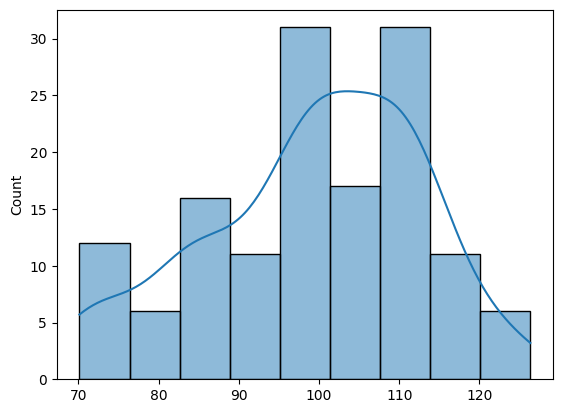

In [94]:
sns.histplot(hipotetical_match, kde=True)

Distribuição dos pontos filtrados

<Axes: ylabel='Count'>

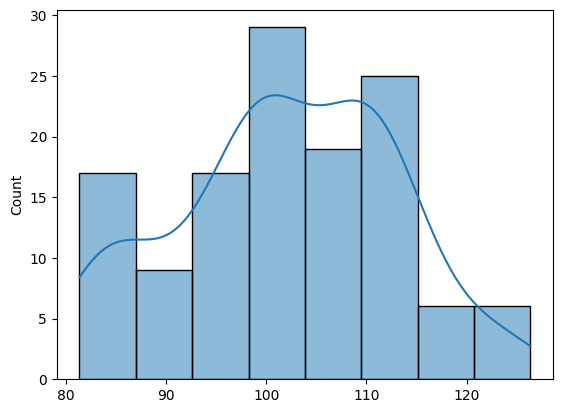

In [95]:
sns.histplot(filtered_hipotetical_match, kde=True)

Percebe-se que nos dois casos, por mais que a distribuição geral se comporte de uma maneira diferente em cada cenário, ambos possuem uma descida relativamente brusca, à direita.

## Modelos Matemáticos


### Log-Normal

A razão por trás da definição de limites em torno da faixa de 95%-125% para rentabilidade aceitável e considerar valores acima de 125% como muito altos está ligada aos seguintes fatores chave:

  Índice CDI: Ao mirar combinar o índice CDI a 100%, o modelo é projetado para replicar uma taxa de renda fixa que espelharia esse referencial. Isso significa que os resultados ideais seriam agrupados em torno de 100%.

  "Perda": Estabelecer um limite inferior a 100% cria uma zona de amortecimento para o que seria considerado uma variação aceitável do alvo. Isso reconhece que, em cenários do mundo real, há algum nível de imprevisibilidade e que desvios menores abaixo dessa média são toleráveis.

  Transferência de Riqueza: Por outro lado, identificar taxas de rentabilidade acima de 125% como indesejavelmente altas é para prevenir cenários que são demasiado otimistas ou resultam em uma transferência de riqueza, o que pode não ser sustentável ou refletir o comportamento típico do mercado.

### Cenário 1: Equilíbrio entre Precisão e Flexibilidade

A distribuição log-normal com mu = 0 e sigma = 0.55 gera um perfil de rentabilidade centrado em 100%, com uma dispersão moderada que permite rentabilidades entre 95% e 100%. Além disso, a assimetria natural da distribuição log-normal acarreta em uma frequência maior de valores acima de 110%, considerados como altos. Este cenário é ideal para representar a maioria dos casos, com uma margem para oscilações realistas do mercado.

<ipython-input-96-ffe5463d1f2a>:7: RuntimeWarning: divide by zero encountered in log
  pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
<ipython-input-96-ffe5463d1f2a>:7: RuntimeWarning: invalid value encountered in divide
  pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


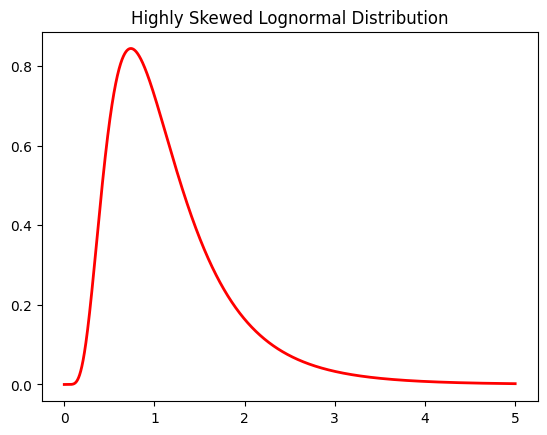

In [96]:
import numpy as np

mu, sigma = 0, .55
s = np.random.lognormal(mu, sigma, 1000)

x = np.linspace(0,5, 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.title('Highly Skewed Lognormal Distribution')
plt.show()

### Cenário 2: Maior Liberdade para Valores Altos
No segundo cenário, com mu = 0 e sigma = 1.44, a distribuição permite uma variação maior para valores abaixo de 100%, com uma cauda mais longa para valores acima do pico, refletindo uma maior frequência de rentabilidades consideradas altas.

<ipython-input-97-782e6247c354>:7: RuntimeWarning: divide by zero encountered in log
  pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
<ipython-input-97-782e6247c354>:7: RuntimeWarning: invalid value encountered in divide
  pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


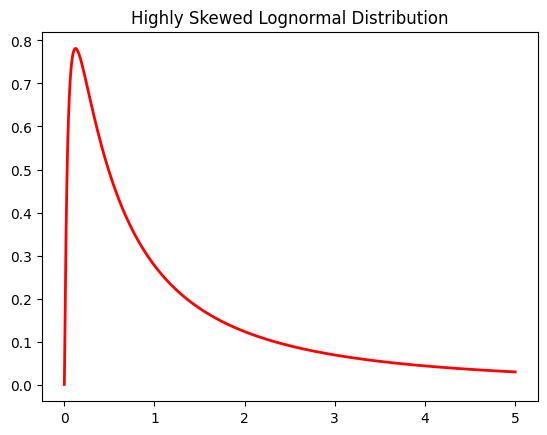

In [97]:
import numpy as np

mu, sigma = 0, 1.44
s = np.random.lognormal(mu, sigma, 1000)

x = np.linspace(0, 5, 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.title('Highly Skewed Lognormal Distribution')
plt.show()

### Cenário 3 - Modelo Ótimo

Para o terceiro cenário, mu = 0 e sigma = 0.36 resultam em uma distribuição mais concentrada em torno de 100%, com desvios menores tanto para baixo quanto para cima. Este seria o cenário ideal, porém menos realista, pois pressupõe uma precisão que pode não ser alcançável na prática.

<ipython-input-98-ad40c9599bd7>:7: RuntimeWarning: divide by zero encountered in log
  pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
<ipython-input-98-ad40c9599bd7>:7: RuntimeWarning: invalid value encountered in divide
  pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


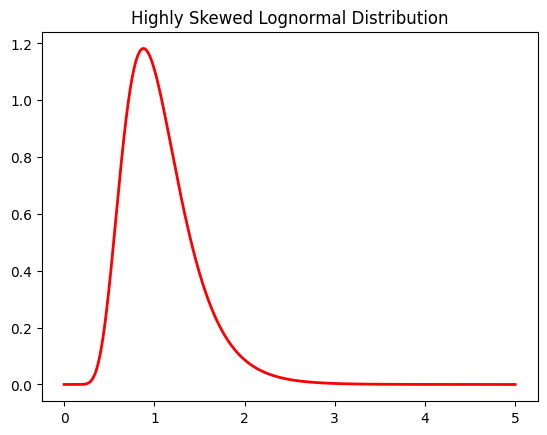

In [98]:
import numpy as np

mu, sigma = 0, .36
s = np.random.lognormal(mu, sigma, 1000)

x = np.linspace(0, 5, 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.title('Highly Skewed Lognormal Distribution')
plt.show()

# Resultados

Após avaliar os cenários propostos, optamos por adotar o Cenário 1 como referência. A distribuição gerada por ele se alinha melhor com o objetivo de reproduzir a rentabilidade próxima ao índice CDI de 100%, enquanto permite uma distribuição de valores que reflete a realidade do mercado, aceitando variações naturais sem buscar o ótimo hipotético.

Essa escolha se justifica pela necessidade de encontrar um equilíbrio entre a precisão dos casamentos e a flexibilidade para acomodar a volatilidade e as variações inerentes às previsões do modelo.